### 1. Problem Definition:
Today, with the highly reputable culinary scene, a question will often arise in a diner's mind: "Where and why am I eating here?" Factors that contribute to this dilemma include the restaurant's atmosphere, service, menu offerings, among others. In this paper, we dive into the task of predicting the cost of food served in various restaurants in different cities in India. We attempt to exploit some data science techniques in a bid to unveil some of the underlying factors that would be influencing the cost of dining out in a particular restaurant, thus trying to point out the wiser way forward for both a consumer and a restaurant owner.

### Import necessary libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### 2. Data Analysis
To solve the existing problem, we first take a look at the dataset of restaurant features such as the title, cuisines, operating hours, location, ratings, and many others. The structural and content analysis of the data gives insight into the involved variables with a possible impact on food cost.

In [2]:
# Load the Data
train_data = pd.read_csv("Data_Train.csv", encoding='latin1')
test_data = pd.read_csv("Data_Test.csv", encoding='latin1')

### 3. EDA conclusion/remark
We find such interesting patterns and relations from within the data using Exploratory Data Analysis (EDA). Our analysis will give key insights that indicate ways to further investigate the causes of such patterns, from discovering the most popular cuisines to identifying the cities where people are spending the highest amounts on average for food.

In [3]:
# Exploratory Data Analysis (EDA)
print(train_data.head())  # View first few rows of the dataset

               TITLE  RESTAURANT_ID  \
0      CASUAL DINING           9438   
1  CASUAL DINING,BAR          13198   
2      CASUAL DINING          10915   
3        QUICK BITES           6346   
4     DESSERT PARLOR          15387   

                                     CUISINES  \
0                 Malwani, Goan, North Indian   
1              Asian, Modern Indian, Japanese   
2  North Indian, Chinese, Biryani, Hyderabadi   
3                            Tibetan, Chinese   
4                                    Desserts   

                                     TIME     CITY        LOCALITY RATING  \
0  11am  4pm, 7:30pm  11:30pm (Mon-Sun)    Thane  Dombivali East    3.6   
1                    6pm  11pm (Mon-Sun)  Chennai       Ramapuram    4.2   
2     11am  3:30pm, 7pm  11pm (Mon-Sun)  Chennai      Saligramam    3.8   
3                 11:30am  1am (Mon-Sun)   Mumbai     Bandra West    4.1   
4                    11am  1am (Mon-Sun)   Mumbai     Lower Parel    3.8   

       

In [4]:
print(train_data.info())  # Get information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TITLE          11687 non-null  object
 1   RESTAURANT_ID  12690 non-null  int64 
 2   CUISINES       12690 non-null  object
 3   TIME           12690 non-null  object
 4   CITY           12578 non-null  object
 5   LOCALITY       12592 non-null  object
 6   RATING         12688 non-null  object
 7   VOTES          11486 non-null  object
 8   COST           12690 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 892.4+ KB
None


In [5]:
print(train_data.describe())  # Summary statistics

       RESTAURANT_ID          COST
count   12690.000000  12690.000000
mean     7759.134121    655.252246
std      4504.874150    627.003540
min         0.000000     20.000000
25%      3863.250000    300.000000
50%      7740.000000    500.000000
75%     11688.750000    800.000000
max     15573.000000  14000.000000


### Data Visualization

Axes(0.125,0.11;0.775x0.77)


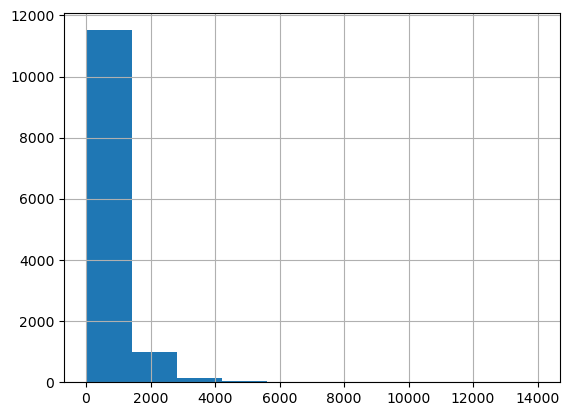

In [6]:
print(train_data['COST'].hist())  # Visualization of the target variable distribution

### Data Preprocessing:
This is followed by a preprocessing journey to clean and bring the raw data into an appropriate format for analysis. This first includes handling the problem of missing values, encoding categorical variables, and possibly creating new features that will capture useful information.


In [7]:
# Handle missing values
train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

In [8]:
# Encode categorical variables
train_data = pd.get_dummies(train_data, columns=['TITLE', 'CUISINES', 'CITY', 'LOCALITY'])
test_data = pd.get_dummies(test_data, columns=['TITLE', 'CUISINES', 'CITY', 'LOCALITY'])

In [9]:
# Split the Data
X = train_data.drop(columns=['RESTAURANT_ID', 'COST'])
y = train_data['COST']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Preprocess 'TIME' column to extract opening and closing hours
train_data['Opening_Hour'] = train_data['TIME'].str.extract(r'(\d{1,2}(:\d{2})?(am|pm))')[0]
train_data['Closing_Hour'] = train_data['TIME'].str.extract(r'(?<=- )(\d{1,2}(:\d{2})?(am|pm))')[0]

In [11]:
# Convert opening and closing hours to datetime format
train_data['Opening_Hour'] = pd.to_datetime(train_data['Opening_Hour'], format='%I:%M%p', errors='coerce').dt.hour
train_data['Closing_Hour'] = pd.to_datetime(train_data['Closing_Hour'], format='%I:%M%p', errors='coerce').dt.hour

In [12]:
# Create a feature to indicate if the restaurant is open on weekends
train_data['Weekend_Open'] = train_data['TIME'].str.contains('Sat|Sun', case=False, na=False).astype(int)

In [13]:
# Drop the original 'TIME' column
train_data.drop(columns=['TIME'], inplace=True)

### Building Machine Learning Models:
Armed with a preprocessed dataset, we would be working on building predictive models that estimate restaurant food costs. We generally train and tune our machine learning model using training data, after pre-processing. We use some of the popular machine learning algorithms such as Random Forest and XGBoost for our model building process.

In [14]:
# Load the test dataset (test.csv)
test_data = pd.read_csv("Data_test.csv", encoding='latin1')

In [15]:
# Handle missing values
test_data.fillna(method='ffill', inplace=True)

In [16]:
# Encode categorical variables
test_data = pd.get_dummies(test_data, columns=['TITLE', 'CUISINES', 'CITY', 'LOCALITY'])

In [17]:
# Drop unnecessary columns (RESTAURANT_ID and TIME)
test_data.drop(columns=['RESTAURANT_ID', 'TIME'], inplace=True)

In [18]:
# Split the Data
X = train_data.drop(columns=['RESTAURANT_ID', 'COST'])
y = train_data['COST']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Check for non-numeric values in each column
non_numeric_columns = test_data.select_dtypes(exclude=['number']).columns
for column in non_numeric_columns:
    non_numeric_values = test_data[column][~test_data[column].astype(str).str.isdigit()]
    print(f"Non-numeric values in {column}:", non_numeric_values.unique())


Non-numeric values in RATING: ['4.3' '4.2' '3.8' '3.6' '3.7' 'NEW' '4.0' '3.4' '3.2' '4.1' '3.0' '-'
 '3.5' '4.5' '3.9' '3.3' '2.9' '3.1' '2.5' '2.8' '4.6' '4.4' '2.7' '4.8'
 '2.6' '4.9' '2.1' '4.7' '2.3' '2.4' '2.2']
Non-numeric values in VOTES: ['564 votes' '61 votes' '350 votes' ... '1697 votes' '749 votes'
 '1239 votes']
Non-numeric values in TITLE_BAKERY: [False  True]
Non-numeric values in TITLE_BAKERY,BEVERAGE SHOP: [False  True]
Non-numeric values in TITLE_BAKERY,CAFÉ: [False  True]
Non-numeric values in TITLE_BAKERY,CASUAL DINING: [False  True]
Non-numeric values in TITLE_BAKERY,DESSERT PARLOR: [False  True]
Non-numeric values in TITLE_BAKERY,QUICK BITES: [False  True]
Non-numeric values in TITLE_BAR: [False  True]
Non-numeric values in TITLE_BAR,CASUAL DINING: [False  True]
Non-numeric values in TITLE_BAR,LOUNGE: [False  True]
Non-numeric values in TITLE_BAR,PUB: [False  True]
Non-numeric values in TITLE_BEVERAGE SHOP: [False  True]
Non-numeric values in TITLE_BEVERAGE SHOP,C